In [174]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from tqdm import tqdm

from networks.cnn import CNN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [175]:
transform = transforms.Compose([transforms.ToTensor()])
# Download CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

#create smaller dataset to test with
mini_train_idx = torch.utils.data.SubsetRandomSampler(np.arange(200)) # get the first 200 images
mini_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, sampler=mini_train_idx) 

Files already downloaded and verified


In [176]:
# Create the model
model = CNN().to(device)
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10

In [ ]:
# Train the model
progress = tqdm(total=len(train_loader)*EPOCHS, desc="Training") # add a progress bar
for epoch in range(EPOCHS):
    for images, labels in train_loader:
        model.train()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress.update(1)
    
    progress.write(f'Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}')

# #saving model
# torch.save(model.state_dict(), "pretrained_cnn.pth")
# print("Saved PyTorch Model State to pretrained_cnn.pth")

Training:  20%|██        | 1570/7820 [4:20:30<17:17:04,  9.96s/it]


KeyboardInterrupt: 

In [ ]:

#loading the pretrained model
model = CNN()
model.load_state_dict(torch.load("pretrained_cnn.pth"))

Saved PyTorch Model State to pretrained_cnn.pth


<All keys matched successfully>

In [ ]:
#testing
model = CNN()
model.load_state_dict(torch.load("pretrained_cnn.pth"))

model.to(device)
model.eval()

transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

criterion = torch.nn.CrossEntropyLoss()

losses = []
accuracies = []

with torch.no_grad():
    for inputs, labels in test_loader:
        #for every batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        accuracy = (torch.max(outputs, dim=1)[1] == labels).to(torch.float32).mean()
        losses.append(loss.cpu().numpy())
        accuracies.append(accuracy.cpu().numpy())

loss, accuracy = np.mean(losses), np.mean(accuracies)

print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Loss: 1.1437, Accuracy: 0.6731


In [261]:
# Fast gradient sign method
def fgsm(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [279]:
# Adversarial test (but technically also train)

epsilons = [0, 0.0005, 0.001, 0.003, 0.007,0.01]
pretrained_model = "pretrained_cnn.pth"
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network
model = CNN().to(device)
model.load_state_dict(torch.load(pretrained_model))
# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def test( model, device, test_loader, epsilon,criterion, optimizer ):
    correct = 0
    adv_examples = []
    for images, labels in test_loader:
        # Send the data and label to the device
        images, labels = images.to(device), labels.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        images.requires_grad = True

        # Forward pass the data through the model
        output = model(images) 
        init_pred = torch.max(output, dim=1)[1] # get the index of the max log-probability
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Collect gradients
        data_grad = images.grad.data

        # Call FGSM Attack
        perturbed_images = fgsm(images, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_images)

        final_pred = torch.max(output, dim=1)[1] # get the index of the max log-probability
        correct_idx = (final_pred == labels)
        correct += sum(correct_idx.to(torch.float32)).item()

        # only get pred that was right buut now wrong
        incorrect_idx = (final_pred != labels) & (init_pred == labels)

        #saving examples of perturbed images for later visualization
        if len(adv_examples) < 5:
            # Save some adv examples for visualization later
            # p is the single perturbed image, y is the correct label, initial and final and pre- and post-fgsm predictions
            for initial, final, p, y in zip(init_pred[incorrect_idx], final_pred[incorrect_idx], perturbed_images[incorrect_idx], labels[incorrect_idx]):
                adv_ex = p.squeeze().detach().cpu().numpy()
                adv_examples.append( (initial.item(), final.item(), y.item(), adv_ex) )
                # returned adv_examples is 1 x batchsize x 4, holding items: pre-fgsm pred, post-fgsm pred, ground truth, post-fgsm image
            
            # Special case for saving 0 epsilon examples
            if epsilon == 0:
                for initial, final in zip(init_pred[correct_idx], final_pred[correct_idx]):
                    adv_ex = perturbed_images.squeeze().detach().cpu().numpy()
                    adv_examples.append( (initial.item(), final.item(), final.item(), adv_ex) )


    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_dataset))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_dataset), final_acc))
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

accuracies = []
examples = []

epsilons = [0, 0.001, 0.003, 0.005, 0.007, 0.1, 0.15] #overwriting epsilon for faster testing
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, criterion, optimizer)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 6952.0 / 10000 = 0.6952
Epsilon: 0.001	Test Accuracy = 6525.0 / 10000 = 0.6525
Epsilon: 0.003	Test Accuracy = 4031.0 / 10000 = 0.4031
Epsilon: 0.005	Test Accuracy = 2012.0 / 10000 = 0.2012
Epsilon: 0.007	Test Accuracy = 913.0 / 10000 = 0.0913
Epsilon: 0.1	Test Accuracy = 0.0 / 10000 = 0.0
Epsilon: 0.15	Test Accuracy = 0.0 / 10000 = 0.0


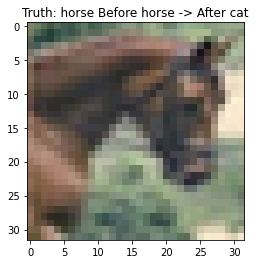

In [283]:
# print the adversarial examples saved during the above program
import matplotlib.pyplot as plt
import torchvision

#img needs to be a tensor that is configured with torchvision.utils.make_grid(img), before after and truth are strings
def imshow(img, before, after, truth):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Truth: {} Before {} -> After {}".format(truth, before, after))
    plt.show()

ex = examples[1][0]
img = torch.tensor(ex[3])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# perturbed image
imshow(torchvision.utils.make_grid(img), classes[ex[0]], classes[ex[1]], classes[ex[2]])
